In [20]:
%cd Vision/data/Outdoor/

[WinError 3] The system cannot find the path specified: 'Vision/data/Outdoor/'
c:\Users\hasan\OneDrive\Documents\GitHub\Vision-Transformer-Image-Dehazing-hasanhd555\Vision\data\Outdoor


In [21]:
%pwd

'c:\\Users\\hasan\\OneDrive\\Documents\\GitHub\\Vision-Transformer-Image-Dehazing-hasanhd555\\Vision\\data\\Outdoor'

In [22]:
import numpy as np
import cv2

def dark_channel_prior(image, window_size=15):
    """
    Compute the dark channel prior of an image.

    Args:
    - image: Input hazy image.
    - window_size: Size of the window for computing the dark channel.

    Returns:
    - dark_channel: Dark channel prior of the input image.
    """
    # Compute the dark channel
    dark_channel = np.min(image, axis=2)
    dark_channel = cv2.erode(dark_channel, np.ones((window_size, window_size), dtype=np.uint8))
    return dark_channel

def estimate_airlight_dcp(image, dark_channel, percentile=0.1):
    """
    Estimate airlight using the Dark Channel Prior method.

    Args:
    - image: Input hazy image.
    - dark_channel: Dark channel prior of the input image.
    - percentile: Percentage of brightest pixels to consider for airlight estimation.

    Returns:
    - airlight: Estimated airlight value.
    """
    # Flatten the dark channel to find the brightest pixels
    dark_channel_flat = dark_channel.flatten()
    
    # Sort the dark channel values in descending order
    sorted_indices = np.argsort(-dark_channel_flat)
    
    # Calculate the number of pixels to consider based on the given percentile
    num_pixels = int(percentile * len(sorted_indices))
    
    # Select the brightest pixels and compute the average color
    brightest_pixels = image.reshape(-1, 3)[sorted_indices[:num_pixels]]
    airlight = np.mean(brightest_pixels, axis=0)
    
    return airlight

# Example usage:
# Load hazy image
image_path = 'test/hazy/03.png'
hazy_image = cv2.imread(image_path)
hazy_image = cv2.cvtColor(hazy_image, cv2.COLOR_BGR2RGB)

# Compute dark channel prior
dark_channel = dark_channel_prior(hazy_image)

# Estimate airlight using DCP
airlight_dcp = estimate_airlight_dcp(hazy_image, dark_channel)

print("Estimated airlight using DCP:", airlight_dcp)




Estimated airlight using DCP: [194.79480729 208.26846875 228.9470625 ]


In [23]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter


def load_image(image_path):
    # Load image and convert to RGB color space
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img=img.astype('uint8') 
    return img

def convert_to_spherical(image):
    # Convert image to spherical coordinates
    r = np.linalg.norm(image, axis=2)
    phi = np.arctan2(image[:,:,1], image[:,:,0])
    theta = np.arccos(image[:,:,2] / (r + 1e-10))  # Add a small epsilon to avoid division by zero
    return r, phi, theta

def kmeans_clustering(spherical_coords, n_clusters=3):
    # Flatten the spherical coordinates
    pixels = np.column_stack((spherical_coords[1].flatten(), spherical_coords[2].flatten()))
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels)
    # Get cluster labels
    cluster_labels = kmeans.labels_
    return cluster_labels.reshape(spherical_coords[0].shape)

def estimate_max_radius(cluster_labels, r):
    # Estimate maximum radius for each cluster
    max_radius = np.zeros(np.max(cluster_labels) + 1)
    for i in range(len(max_radius)):
        max_radius[i] = np.max(r[cluster_labels == i])
    return max_radius

def estimate_transmission(r, max_radius, cluster_labels):
    # Estimate transmission for each pixel
    transmission_estimated = np.zeros_like(r)
    for i in range(len(max_radius)):
        transmission_estimated[cluster_labels == i] = r[cluster_labels == i] / max_radius[i]
    return transmission_estimated

def regularize_transmission(transmission, image, sigma=0.1, lam=0.1):
    # Regularize transmission
    regularized_transmission = np.zeros_like(transmission)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            neighborhood = image[max(0, x-1):min(x+2, image.shape[0]), max(0, y-1):min(y+2, image.shape[1])]
            t_diff = transmission[x, y] - transmission[neighborhood[:,:,0], neighborhood[:,:,1]]
            i_diff = np.linalg.norm(image[x, y] - image[neighborhood[:,:,0], neighborhood[:,:,1]], axis=2)
            regularization_term = np.sum(t_diff**2 / (2 * sigma**2) + lam * t_diff * i_diff)
            regularized_transmission[x, y] = transmission[x, y] - regularization_term
    return regularized_transmission

def dehaze_image(image, transmission, airlight):
    # Dehaze the image
    dehazed_image = np.zeros_like(image)
    for i in range(3):
        dehazed_image[:,:,i] = ((image[:,:,i] - airlight[i]) / np.maximum(transmission, 0.1)) + airlight[i]
    return np.clip(dehazed_image, 0, 255).astype(np.uint8)


In [24]:
def post_proc(image):
    """
    Perform color correction on the input image using histogram equalization.

    Args:
    - image: Input image (hazy or dehazed).

    Returns:
    - corrected_image: Color-corrected image.
    """
    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Apply histogram equalization to the L channel
    lab_image[:,:,0] = cv2.equalizeHist(lab_image[:,:,0])
    
    # Convert the LAB image back to RGB color space
    corrected_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
    
    return corrected_image


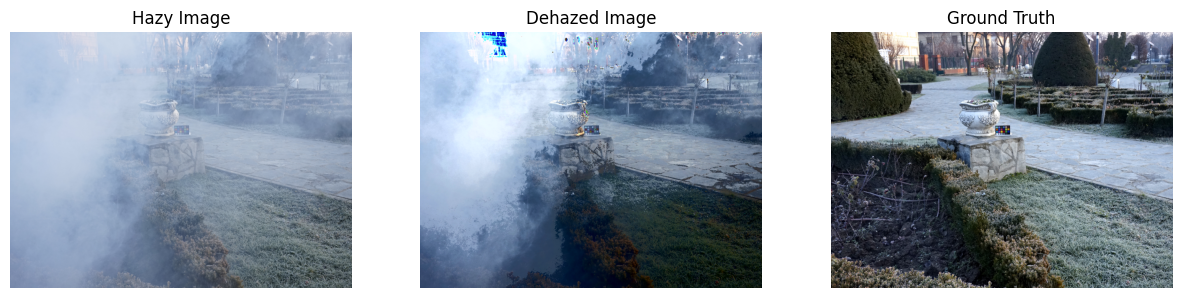

True

In [25]:

# Example usage
image_path = 'test/hazy/03.png'
hazy_image = load_image(image_path)

# Subtract airlight to get IA(x)
airlight = np.array([255, 255, 255])  # Sample airlight value, should be estimated
IA = hazy_image - airlight

# Convert IA to spherical coordinates
r, phi, theta = convert_to_spherical(IA)

# Cluster pixels according to [phi(x), theta(x)]
cluster_labels = kmeans_clustering((r, phi, theta))

# Estimate maximum radius for each cluster
max_radius = estimate_max_radius(cluster_labels, r)

# Estimate transmission
transmission_estimated = estimate_transmission(r, max_radius, cluster_labels)

# Regularize transmission
regularized_transmission = gaussian_filter(transmission_estimated, sigma=0.1)

# Dehaze the image
dehazed_image = dehaze_image(hazy_image, regularized_transmission, airlight_dcp)
dehazed_image = post_proc(dehazed_image)

#hazy_image = hazy_image[:, :, ::-1].astype("float32")



GT_image = load_image('test/GT/03.png')
#GT_image = GT_image[:, :, ::-1].astype("float32")
# Displaying the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(hazy_image)
plt.title('Hazy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(dehazed_image)
plt.title('Dehazed Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(GT_image)
plt.title('Ground Truth')
plt.axis('off')

plt.show()

cv2.imwrite('dehazed_image.png', dehazed_image)



In [7]:
#create a folder color_Correct generate dehazed images for each image in train/hazy and test/hazy and store it in
#color_Correct folder in train/noisy and test/noisy respectively also store the ground truth images in train/GT and test/GT respectively
# Define directories

import os
train_hazy_dir = 'train/hazy/'
test_hazy_dir = 'test/hazy/'
train_gt_dir = 'train/GT/'
test_gt_dir = 'test/GT/'

# Define output directories for dehazed and color-corrected images
output_train_noisy_dir = 'color_correct/train/noisy'
output_test_noisy_dir = 'color_correct/test/noisy'
output_train_gt_dir = 'color_correct/train/GT'
output_test_gt_dir = 'color_correct/test/GT'

# Create output directories if they don't exist
os.makedirs(output_train_noisy_dir, exist_ok=True)
os.makedirs(output_test_noisy_dir, exist_ok=True)
os.makedirs(output_train_gt_dir, exist_ok=True)
os.makedirs(output_test_gt_dir, exist_ok=True)

def estimate_airlight(image):
    dark_channel = dark_channel_prior(image)
    return estimate_airlight_dcp(image, dark_channel)

#add gt images to the output directories
for image_name in os.listdir(train_gt_dir):
    #print(image_name)
    image_path = os.path.join(train_gt_dir, image_name)
    image = load_image(image_path)
    output_path = os.path.join(output_train_gt_dir, image_name)
    cv2.imwrite(output_path, image)

print("Ground truth images train copied to output directories")

for image_name in os.listdir(test_gt_dir):
    image_path = os.path.join(test_gt_dir, image_name)
    image = load_image(image_path)
    output_path = os.path.join(output_test_gt_dir, image_name)
    cv2.imwrite(output_path, image)

print("Ground truth images test copied to output directories")


KeyboardInterrupt: 

In [ ]:

# Define airlight estimation method

# Dehaze and color correct images in the train set
for filename in os.listdir(train_hazy_dir):
    if filename.endswith('.png'):
        hazy_image = load_image(os.path.join(train_hazy_dir, filename))
        # Dehaze the image
        airlight = estimate_airlight(hazy_image)
        IA = hazy_image - np.array([255, 255, 255])
        r, phi, theta = convert_to_spherical(IA)
        cluster_labels = kmeans_clustering((r, phi, theta))
        max_radius = estimate_max_radius(cluster_labels, r)
        transmission_estimated = estimate_transmission(r, max_radius, cluster_labels)
        regularized_transmission = gaussian_filter(transmission_estimated, sigma=0.1)
        dehazed_image = dehaze_image(hazy_image, regularized_transmission, airlight)
        dehazed_image = post_proc(dehazed_image)

        # Save dehazed and color-corrected image
        cv2.imwrite(os.path.join(output_train_noisy_dir, filename), cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))

        # Copy ground truth image to the corresponding directory
        gt_image = cv2.imread(os.path.join(train_gt_dir, filename))
        cv2.imwrite(os.path.join(output_train_gt_dir, filename), gt_image)


In [ ]:

# Dehaze and color correct images in the test set

for filename in os.listdir(test_hazy_dir):
    if filename.endswith('.png'):
        hazy_image = load_image(os.path.join(test_hazy_dir, filename))

        # Dehaze the image
        airlight = estimate_airlight(hazy_image)
        IA = hazy_image - np.array([255, 255, 255])
        r, phi, theta = convert_to_spherical(IA)
        cluster_labels = kmeans_clustering((r, phi, theta))
        max_radius = estimate_max_radius(cluster_labels, r)
        transmission_estimated = estimate_transmission(r, max_radius, cluster_labels)
        regularized_transmission = gaussian_filter(transmission_estimated, sigma=0.1)
        dehazed_image = dehaze_image(hazy_image, regularized_transmission, airlight)
        dehazed_image = post_proc(dehazed_image)

        # Save dehazed and color-corrected image
        cv2.imwrite(os.path.join(output_test_noisy_dir, filename), cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))

        # Copy ground truth image to the corresponding directory
        gt_image = cv2.imread(os.path.join(test_gt_dir, filename))
        cv2.imwrite(os.path.join(output_test_gt_dir, filename), gt_image)

print("Dehazing and color correction complete.")

Dehazing and color correction complete.


In [ ]:
#Add gt images to the color_correct folder
import os
